## Simple Uni V2 Tree - Finite Index Token

- Assumptions:
    - Uses Simple Tree
    - Uses stablecoins (ie, USDC and USDT) to control for impermanent loss
    - Includes state machine to handle finite supply of index tokens

- LPs include:
    - USDC-USDT
    - USDC-iUSDC
 
- To run locally, download [notebook](https://github.com/SYS-Labs/pachira-python/blob/main/notebook/docs/simple_tree_pt2.ipynb) from [SYS-Labs repos](https://github.com/SYS-Labs/pachira-python)

In [1]:
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import scipy.stats as stats 
import statsmodels.api as sm
import seaborn as sns

from uniswappy import *

### Script params

In [2]:
init_tkn_lp = 100000
tkn_delta_param = 1000
tkn_invest_amt = 100
tkn_nm = 'USDC'
itkn_nm = 'iUSDC'
usd_nm = 'USDT'
iusd_nm = 'iUSDT'

### Simulate price data

Text(0.5, 0, 'Date')

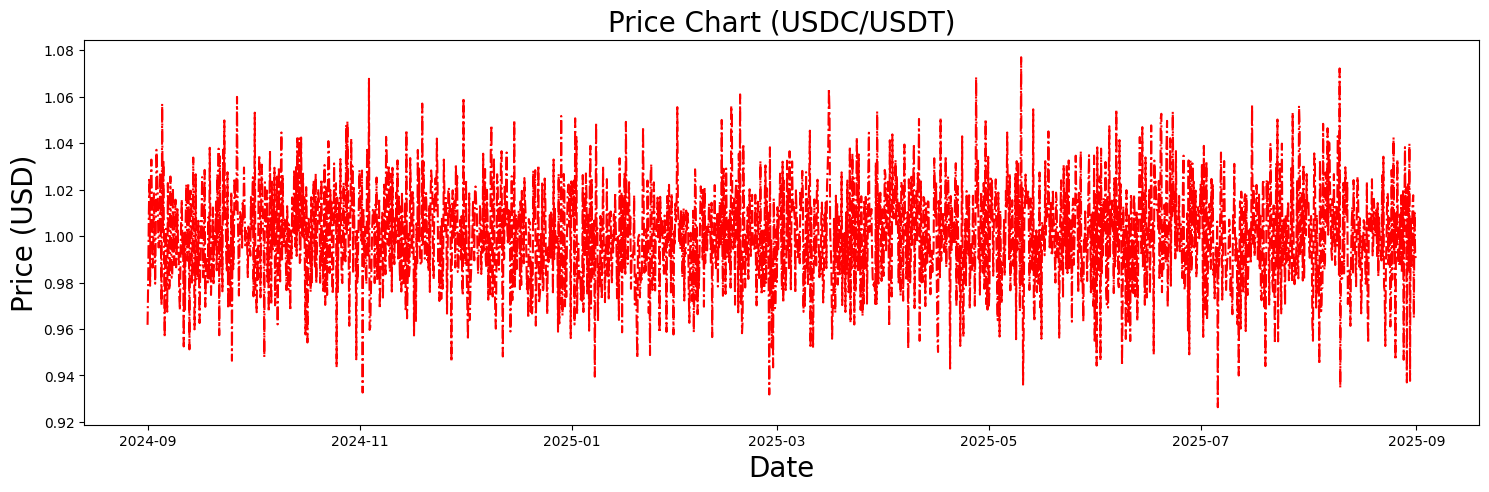

In [3]:
# *************************
# *** Simulation
# *************************
n_sim_runs = 2000
seconds_year = 31536000
shape = 2000
scale = 0.0005

p_arr = np.random.gamma(shape = shape, scale = scale, size = n_sim_runs)

n_runs = len(p_arr)-1    
dt = datetime.timedelta(seconds=seconds_year/n_sim_runs)
dates = [datetime.datetime.strptime("2024-09-01", '%Y-%m-%d') + k*dt for k in range(n_sim_runs)]   

x_val = np.arange(0,len(p_arr))
fig, (USD_ax) = plt.subplots(nrows=1, sharex=False, sharey=False, figsize=(18, 5))
USD_ax.plot(dates, p_arr, color = 'r',linestyle = 'dashdot', label='initial invest') 
USD_ax.set_title(f'Price Chart ({tkn_nm}/{usd_nm})', fontsize=20)
USD_ax.set_ylabel('Price (USD)', size=20)
USD_ax.set_xlabel('Date', size=20)

### Initialization Params

In [4]:
user_nm = 'user0'
tkn_amount = init_tkn_lp 
dai_amount = p_arr[0]*tkn_amount 

### Initialize Left DEX Tree

In [5]:
dai1 = ERC20(usd_nm, "0x111")
tkn1 = ERC20(tkn_nm, "0x09")
exchg_data = UniswapExchangeData(tkn0 = tkn1, tkn1 = dai1, symbol="LP", address="0x011")

TKN_amt = TokenDeltaModel(tkn_delta_param)
TKN_amt_arb = TokenDeltaModel(100)

lp1_state = MarkovState(stochastic = True)
iVault1 = IndexVault('iVault1', "0x7")

factory = UniswapFactory(f"{tkn_nm} pool factory", "0x2")
lp = factory.deploy(exchg_data)
Join().apply(lp, user_nm, tkn_amount, dai_amount)

tkn2 = ERC20(tkn_nm, "0x09")
itkn1 = IndexERC20(itkn_nm, "0x09", tkn1, lp)
exchg_data1 = UniswapExchangeData(tkn0 = tkn2, tkn1 = itkn1, symbol="LP1", address="0x012")
lp1 = factory.deploy(exchg_data1)
JoinTree().apply(lp1, user_nm, iVault1, 10000)

# Re-balance LP price after JoinTree
SwapDeposit().apply(lp, dai1, user_nm, lp.get_reserve(tkn1) - lp.get_reserve(dai1))

lp.summary()
lp1.summary()

Exchange USDC-USDT (LP)
Reserves: USDC = 110000.0, USDT = 110000.0
Liquidity: 109981.58198275481 

Exchange USDC-iUSDC (LP1)
Reserves: USDC = 9972.071706380653, iUSDC = 4779.546410096932
Liquidity: 6903.765604759538 



#### Take an investment position

In [6]:
tkn_invest = 100
invested_user_nm = 'invested_user'

SwapIndexMint(iVault1, opposing = False).apply(lp, tkn1, invested_user_nm, tkn_invest)
mint_itkn1_deposit = lp1.convert_to_human(iVault1.index_tokens[itkn_nm]['last_lp_deposit'])
lp1_state.next_state(mint_itkn1_deposit) 
SwapDeposit().apply(lp1, itkn1, invested_user_nm, mint_itkn1_deposit)

lp.summary()
lp1.summary()

lp_invest_track  = lp.get_liquidity_from_provider(invested_user_nm)
lp1_invest_track  = lp1.get_liquidity_from_provider(invested_user_nm)

# Redeem from parent
tkn_redeem_parent = LPQuote(False).get_amount_from_lp(lp, tkn1, lp_invest_track)

# Redeem from tree (child + parent)
itkn_redeem_child = LPQuote(False).get_amount_from_lp(lp1, itkn1, lp1_invest_track)
tkn_redeem_tree = LPQuote(False).get_amount_from_lp(lp, tkn1, itkn_redeem_child) 

print(f'{tkn_redeem_parent:.3f} USDC redeemed from {lp_invest_track:.3f} LP tokens if {tkn_invest:.1f} invested USDC immediately pulled from parent')
print(f'{tkn_redeem_tree:.3f} USDC redeemed from {lp1_invest_track:.3f} LP1 tokens if {tkn_invest:.1f} invested USDC immediately pulled from tree')

Exchange USDC-USDT (LP)
Reserves: USDC = 110100.0, USDT = 110000.0
Liquidity: 110031.48717135024 

Exchange USDC-iUSDC (LP1)
Reserves: USDC = 9972.071706380653, iUSDC = 4829.451598692356
Liquidity: 6939.660517668905 

99.700 USDC redeemed from 49.905 LP tokens if 100.0 invested USDC immediately pulled from parent
99.403 USDC redeemed from 35.895 LP1 tokens if 100.0 invested USDC immediately pulled from tree


#### Simulate trading

In [7]:
arb = CorrectReserves(lp, x0 = 1)
arb1 = Arbitrage(lp1, lp1_state) 

TKN_amt = TokenDeltaModel(tkn_delta_param)

lp_direct_invest_arr = []; lp1_direct_invest_arr = []; lp1_tree_invest_arr = []; 
pTKN_DAI_arr = []; pTKN_iTKN_arr = []
fee_lp_arr  = []; fee_lp1_arr  = [];

for k in range(n_sim_runs):

    #if(k % 100 == 0 and k != 0): print(f'Processing event {k}')
    
    # *****************************
    # ***** Parent Arbitrage ******
    # *****************************   
    arb.apply(p_arr[k])

    # *****************************
    # ***** Child Arbitrage ******
    # *****************************       
    amt_arb1 = TKN_amt_arb.delta()   
    arb1.apply(1, user_nm, amt_arb1)
    arb1.update_state(itkn1)    

    mint_tkn1_amt = 0.5*TKN_amt.delta()
    SwapIndexMint(iVault1, opposing = False).apply(lp, tkn1, user_nm, mint_tkn1_amt)
    mint_itkn1_deposit = lp1.convert_to_human(iVault1.index_tokens[itkn_nm]['last_lp_deposit'])
    lp1_state.next_state(mint_itkn1_deposit)   
    vault_lp1_amt = lp1_state.get_current_state('dVault')  
    burned_itkn1_amt = lp1_state.get_current_state('dBurned') 

    ## WithdrawSwap burned token from parent LP
    if(burned_itkn1_amt > 0):
        total_tkn_w_swap = LPQuote(False).get_amount_from_lp(lp, tkn1, burned_itkn1_amt)
        amt_out = RemoveLiquidity().apply(lp, tkn1, user_nm, total_tkn_w_swap/2)    

    ## Balance LP1: TKN/iTKN
    if(vault_lp1_amt > 0):
        # A portion of aquired token is coming from newly minted, while the remainder is coming from held 
        amt_tkn = LPQuote(False).get_amount_from_lp(lp, tkn1, vault_lp1_amt) 
        price_tkn = amt_tkn/vault_lp1_amt 
        AddLiquidity(price_tkn).apply(lp1, itkn1, user_nm, vault_lp1_amt)        
    elif(vault_lp1_amt < 0):
        # A portion of removed token is getting held, while the remainder is getting burned
        RemoveLiquidity().apply(lp1, itkn1, user_nm, abs(vault_lp1_amt))  

    # *****************************
    # ***** Random Swapping ******
    # *****************************       
    Swap().apply(lp, tkn1, user_nm, TKN_amt.delta()) 
    Swap().apply(lp, dai1, user_nm, TKN_amt.delta()) 

    # conservatively assume 10% of tokens held outside vault are traded
    held_tokens = lp1_state.get_current_state('Held')
    if(held_tokens > 0):
        tradable_itkn1_amt = 0.1*held_tokens
        Swap().apply(lp1, tkn2, user_nm, LPQuote(False).get_amount_from_lp(lp, tkn1, tradable_itkn1_amt))  
        Swap().apply(lp1, itkn1, user_nm, tradable_itkn1_amt)

    # *****************************
    # ******* Data Capture ********
    # *****************************

    # price
    pTKN_DAI_arr.append(LPQuote().get_price(lp, tkn1)) 
    pTKN_iTKN_arr.append(LPQuote().get_price(lp1, tkn1)) 


    # investment performance
    tkn_redeem_parent = LPQuote(False).get_amount_from_lp(lp, tkn1, lp_invest_track)
    itkn_redeem_child = LPQuote(False).get_amount_from_lp(lp1, itkn1, lp1_invest_track)    
    tkn_redeem_tree = LPQuote(False).get_amount_from_lp(lp, tkn1, itkn_redeem_child)     

    lp_direct_invest_arr.append(tkn_redeem_parent)
    lp1_direct_invest_arr.append(LPQuote(True).get_amount_from_lp(lp1, itkn1, lp1_invest_track))
    lp1_tree_invest_arr.append(tkn_redeem_tree)

    # DEX Fees     
    fee_lp_arr.append(TreeAmountQuote().get_tot_y(lp, lp.get_fee(tkn1), lp.get_fee(dai1)))
    fee_lp1_arr.append(TreeAmountQuote().get_tot_y(lp1, lp1.get_fee(tkn2), lp1.get_fee(itkn1)))

lp.summary()
lp1.summary()

# Redeem from parent
tkn_redeem_parent = LPQuote(False).get_amount_from_lp(lp, tkn1, lp_invest_track)

# Redeem from tree (child + parent)
itkn_redeem_child = LPQuote(False).get_amount_from_lp(lp1, itkn1, lp1_invest_track) 
tkn_redeem_tree = LPQuote(False).get_amount_from_lp(lp, tkn1, itkn_redeem_child) 

print(f'{tkn_redeem_parent:.3f} USDC redeemed from {lp_invest_track:.3f} LP tokens if {tkn_invest:.1f} invested USDC pulled from parent (lp)')
print(f'{tkn_redeem_tree:.3f} USDC redeemed from {lp1_invest_track:.3f} LP1 tokens if {tkn_invest:.1f} invested USDC pulled from tree (lp + lp1)')

Exchange USDC-USDT (LP)
Reserves: USDC = 172597.15239656687, USDT = 170673.23042983105
Liquidity: 163600.22321090166 

Exchange USDC-iUSDC (LP1)
Reserves: USDC = 27589.713494926822, iUSDC = 13728.210036376851
Liquidity: 16444.537890036318 

105.125 USDC redeemed from 49.905 LP tokens if 100.0 invested USDC pulled from parent (lp)
125.916 USDC redeemed from 35.895 LP1 tokens if 100.0 invested USDC pulled from tree (lp + lp1)


In [8]:
lp1_state.check_states()
lp1_state.inspect_states(tail = True, num_states = 5)

Amount of tokens retained across states: PASS


,Mint,Held,Vault,Burned,dHeld,dVault,dBurned
1996,3.672169,5699.724602,16349.696683,75914.679914,1019.822651,-1057.507966,92.619687
1997,54.717798,4561.333282,17372.998629,76033.441457,-1138.391320,1023.301946,118.761542
1998,86.606713,4413.812972,17544.176008,76064.502185,-147.520310,171.177379,31.060728
1999,104.103309,5678.616934,16291.099198,76139.381747,1264.803962,-1253.076810,74.879562
2000,6.483054,6825.802726,15227.106060,76160.292401,1147.185792,-1063.993138,20.910654


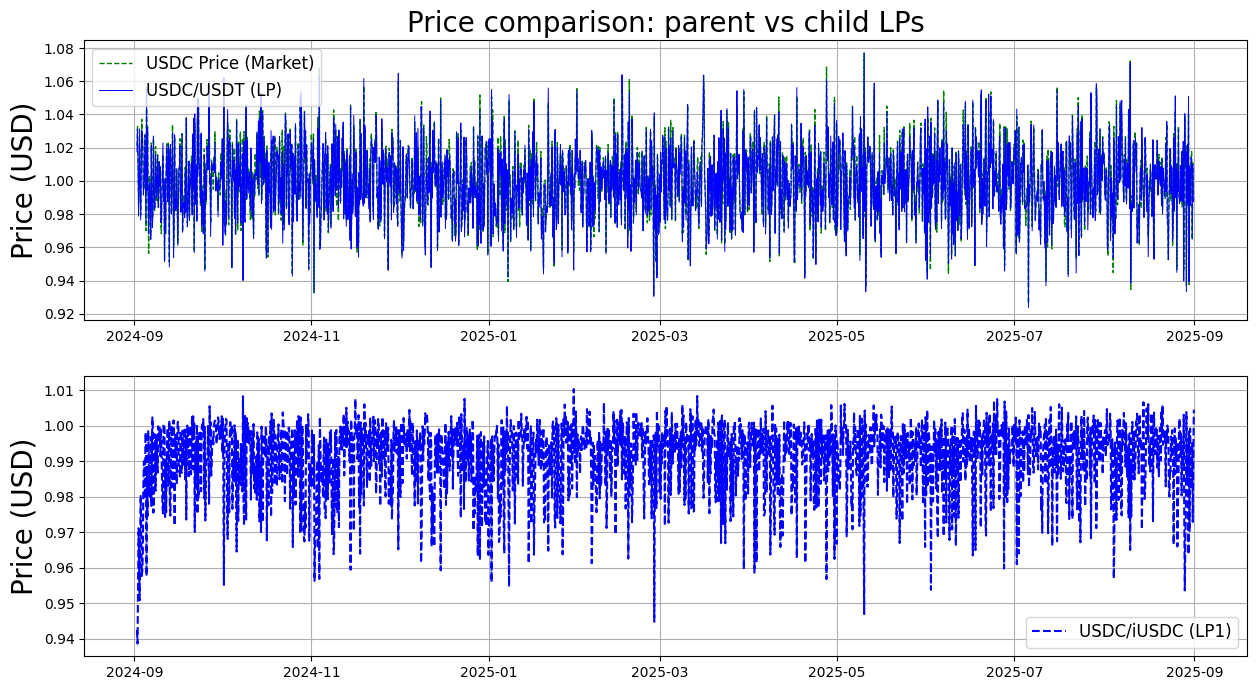

In [9]:
fig, (TKN_ax, DAI_ax) = plt.subplots(nrows=2, sharex=False, sharey=False, figsize=(15, 8))

strt_pt = 5

TKN_ax.plot(dates[strt_pt:], p_arr[strt_pt:], color = 'g',linestyle = 'dashed', linewidth=1, label=f'{tkn_nm} Price (Market)') 
TKN_ax.plot(dates[strt_pt:], pTKN_DAI_arr[strt_pt:], color = 'b',linestyle = '-', linewidth=0.7, label=f'{tkn_nm}/{usd_nm} (LP)') 

TKN_ax.set_title('Price comparison: parent vs child LPs', fontsize=20)
TKN_ax.set_ylabel('Price (USD)', size=20)
TKN_ax.legend(fontsize=12)
TKN_ax.grid()

DAI_ax.plot(dates[strt_pt:], pTKN_iTKN_arr[strt_pt:], color = 'b',linestyle = 'dashed', label=f'{tkn_nm}/{itkn_nm} (LP1)') 
DAI_ax.set_ylabel('prices', size=20)
DAI_ax.set_ylabel('Price (USD)', size=20)
DAI_ax.legend(fontsize=12)
DAI_ax.grid()

Text(0, 0.5, 'Frequency')

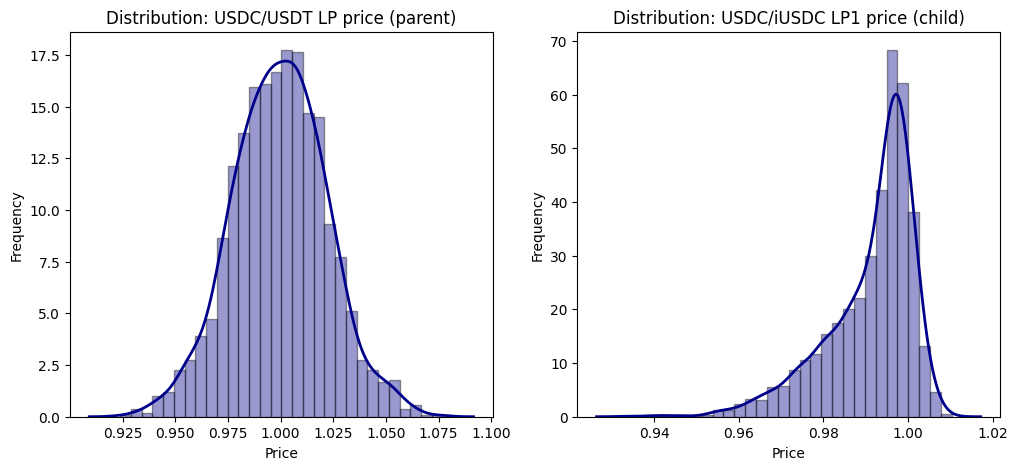

In [10]:
y1_samp = stats.gamma.rvs(a=2000, scale=0.0005, size=10000)

fig, ax = plt.subplots(1, 2, figsize=(12,5))

sns.distplot(pTKN_DAI_arr, hist=True, kde=True, bins=int(30), color = 'darkblue',
             hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 2}, ax=ax[0])

sns.distplot(pTKN_iTKN_arr, hist=True, kde=True, bins=int(30), color = 'darkblue',
             hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 2}, ax=ax[1])

ax[0].set_title(f'Distribution: {tkn_nm}/{usd_nm} LP price (parent)')
ax[0].set_xlabel('Price')
ax[0].set_ylabel('Frequency')

ax[1].set_title(f'Distribution: {tkn_nm}/{itkn_nm} LP1 price (child)')
ax[1].set_xlabel('Price')
ax[1].set_ylabel('Frequency')

Text(0, 0.5, '$100 USD Investment')

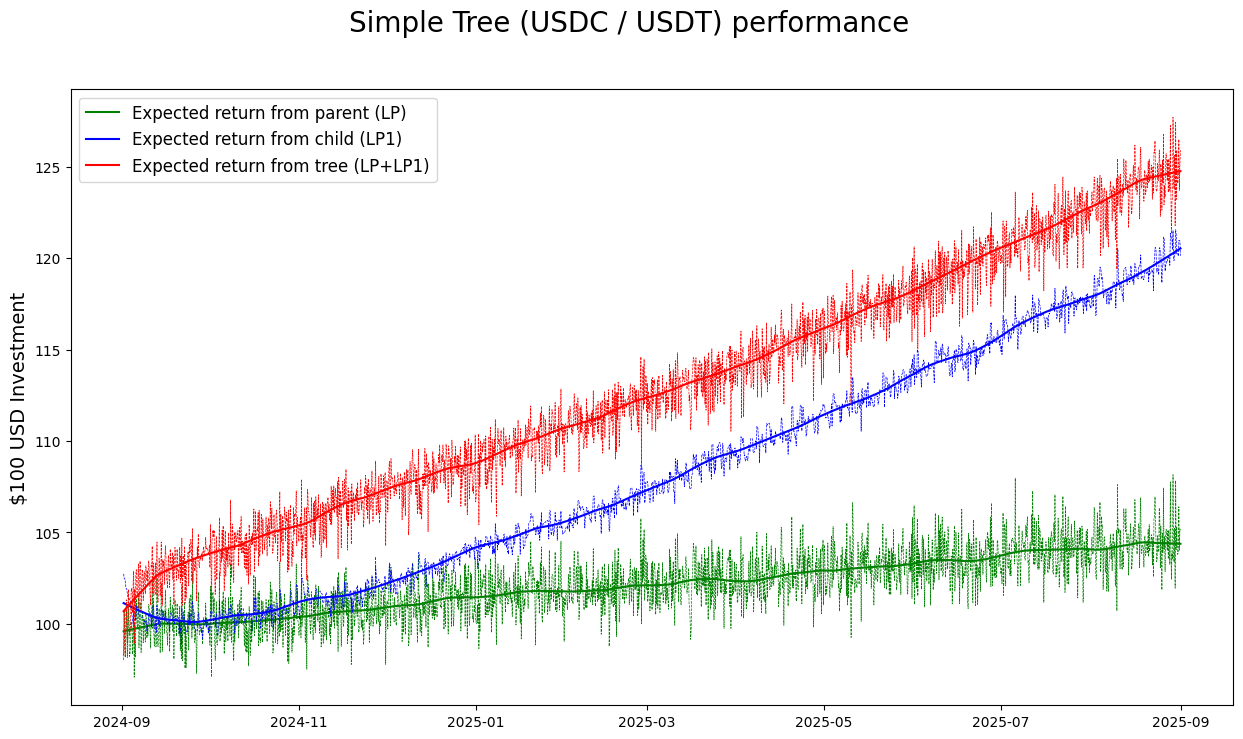

In [11]:
lowess = sm.nonparametric.lowess
x = range(0,n_sim_runs)
res = lowess(lp_direct_invest_arr, x, frac=1/15); sm_lp_direct = res[:,1]
res = lowess(lp1_direct_invest_arr, x, frac=1/15); sm_lp1_direct = res[:,1]
res = lowess(lp1_tree_invest_arr, x, frac=1/15); sm_lp1_tree= res[:,1]

strt_ind = 3

fig, (p_ax) = plt.subplots(nrows=1, sharex=True, sharey=False, figsize=(15, 8))
fig.suptitle('Simple Tree (USDC / USDT) performance ', fontsize=20)
p_ax.plot(dates[strt_ind:], lp_direct_invest_arr[strt_ind:], linestyle='dashed', linewidth=0.5, color = 'g') 
p_ax.plot(dates[strt_ind:], sm_lp_direct[strt_ind:], color = 'g', label = 'Expected return from parent (LP)') 
p_ax.plot(dates[strt_ind:], lp1_direct_invest_arr[strt_ind:], linestyle='dashed', linewidth=0.5, color = 'b')
p_ax.plot(dates[strt_ind:], sm_lp1_direct[strt_ind:], color = 'b', label = 'Expected return from child (LP1)') 
p_ax.plot(dates[strt_ind:], lp1_tree_invest_arr[strt_ind:], linestyle='dashed', linewidth=0.5, color = 'r')
p_ax.plot(dates[strt_ind:], sm_lp1_tree[strt_ind:], color = 'r', label = 'Expected return from tree (LP+LP1)') 
p_ax.legend( fontsize=12)
p_ax.set_ylabel("$100 USD Investment", fontsize=14)

In [12]:
print(f'{tkn_invest:.3f} TKN before is worth {sm_lp_direct[-1]:.3f} TKN after direct investment into parent (lp)') 
print(f'{tkn_invest:.3f} TKN before is worth {sm_lp1_direct[-1]:.3f} TKN after direct investment into child (lp1)') 
print(f'{tkn_invest:.3f} TKN before is worth {sm_lp1_tree[-1]:.3f} TKN after investment into simple tree (lp + lp1)')

100.000 TKN before is worth 104.378 TKN after direct investment into parent (lp)
100.000 TKN before is worth 120.536 TKN after direct investment into child (lp1)
100.000 TKN before is worth 124.762 TKN after investment into simple tree (lp + lp1)


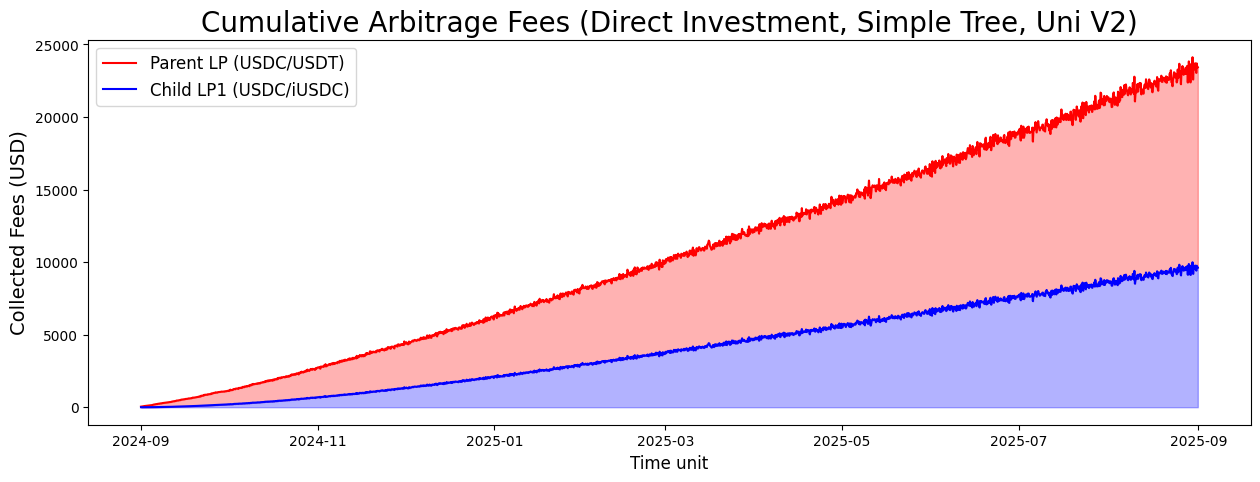

In [13]:
t = np.arange(0,len(fee_lp_arr))

fee_lpB = np.array(fee_lp1_arr)
fee_lpA = fee_lpB+np.array(fee_lp_arr)

fig = plt.figure(figsize=(15, 5))

plt.plot(dates, fee_lpA, color = 'r', label = f'Parent LP ({tkn_nm}/{usd_nm})')
plt.fill_between(dates, fee_lpB, fee_lpA, alpha=0.3, color='r')

plt.plot(dates, fee_lpB, color = 'b', label = f'Child LP1 ({tkn_nm}/{itkn_nm})') 
plt.fill_between(dates, np.repeat(0,len(fee_lp_arr)), fee_lpB, alpha=0.3, color='b')

plt.title('Cumulative Arbitrage Fees (Direct Investment, Simple Tree, Uni V2)', fontsize = 20)
plt.xlabel("Time unit", fontsize=12)
plt.ylabel("Collected Fees (USD)", fontsize=14) 

plt.legend(fontsize=12)